## User story: 'As a LightBox user, I want to receive recommendations for movies so that I can reduce the time it takes to explore movies I like.'

Apply recommendation techniques in Python.

1) Demographic Filtering

All the users have same recommandations

2)Content Based Filtering

similarity with other movies

User=> movie <=> similar movies => recommandations

3) Collaborative Filtering

User=> movie <=> similar users => recommandations

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  1 19:26:47 2020


@author: User
https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

# 8 - Task 3
# User story: 'As a LightBox user, I want to receive recommendations for movies so that I can reduce the time it takes to explore movies I like.'
# Apply
"""

#understand data and clean 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel


#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer


# Parse the stringified features into their corresponding python objects
from ast import literal_eval
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer



# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity







In [2]:




def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan




# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []



# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])



In [3]:
revenueThreshold={'no':0, 'low':1000, 'medium':100000, 'high':1000000, 'toomuch':100000000}
budgetThreshold= {'no':0, 'low':1000, 'medium':100000, 'high':1000000, 'toomuch':100000000}
popularityThreshold={'no':0, 'low':0.38, 'medium':1.1, 'high':3.6, 'toomuch':20}
vote_averageThreshold= {'no':0, 'low':5, 'medium':6, 'high':6.8, 'toomuch':8}
vote_countThreshold= {'no':0, 'low':3, 'medium':10, 'high':34, 'toomuch':100}
vote_countThreshold= {'no':0, 'low':3, 'medium':10, 'high':34, 'toomuch':100}
yearThreshold={'no':0, 'low':1992, 'medium':2004, 'high':2011}
# 25% 50% 75%
#pop 0.4 1.1 3.6
#va 5 6 6.8
#vc 3 10 34 
#year 92 04 11

In [4]:
revenueMin=revenueThreshold['high']
budgetMin=budgetThreshold['high']
popularityMin=popularityThreshold['high']
vote_averageMin=vote_averageThreshold['high']
vote_countMin=vote_countThreshold['high']
yearMin=yearThreshold['high']

In [5]:
#import data
dfmetadata=pd.read_csv('./data/movies_metadata.csv')
dfm=dfmetadata.copy()

dfkewords=pd.read_csv('./data/keywords.csv')
dfk=dfkewords.copy()

dfcredits=pd.read_csv('./data/credits.csv')
dfc=dfcredits.copy()


#dfratings=pd.read_csv('./data/ratings.csv')
#dfr=dfratings.copy()

C:\Users\User\anaconda3\envs\surpriseEnv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
listDel=['adult','belongs_to_collection','homepage', 'imdb_id', 'original_title', 'poster_path', 'tagline','video']
dfm.drop(columns=listDel, inplace=True, errors='raise')

In [7]:
dfm.dtypes

budget                   object
genres                   object
id                       object
original_language        object
overview                 object
popularity               object
production_companies     object
production_countries     object
release_date             object
revenue                 float64
runtime                 float64
spoken_languages         object
status                   object
title                    object
vote_average            float64
vote_count              float64
dtype: object

In [8]:
dfk.dtypes

id           int64
keywords    object
dtype: object

In [9]:
dfc.dtypes

cast    object
crew    object
id       int64
dtype: object

In [10]:
#delete duplicate
dfm.drop_duplicates(keep = 'first', inplace = True) 
dfm.drop_duplicates(subset ='id', keep = 'first', inplace = True) 
#delete all NaN id
dfm = dfm.drop(dfm.loc[dfm['id'].isnull()].index) #delete the rows with NULLS values in 'id'
dfm["id"] = pd.to_numeric(dfm["id"],errors='coerce')#force all the values to be numeric
dfm['id']=pd.to_numeric(dfm['id'],errors='coerce')
dfm.drop(dfm.loc[dfm['id'].isnull()].index, inplace = True)
dfm['id'] = dfm['id'].astype(int)

In [11]:
dfm.dtypes

budget                   object
genres                   object
id                        int32
original_language        object
overview                 object
popularity               object
production_companies     object
production_countries     object
release_date             object
revenue                 float64
runtime                 float64
spoken_languages         object
status                   object
title                    object
vote_average            float64
vote_count              float64
dtype: object

In [12]:
# delete unecessary columns
listDel2=[ 'original_language', 
       'production_companies', 'production_countries',
        'spoken_languages', 'status']
dfm.drop(columns=listDel2, inplace=True, errors='raise')

In [13]:
df1 = pd.merge(dfm, dfk, on='id')
df1= df1.merge(dfc,on='id')


df1.head(2)

,budget,genres,id,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,keywords,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",21.9469,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.0155,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."


In [14]:
df1.columns

Index(['budget', 'genres', 'id', 'overview', 'popularity', 'release_date',
       'revenue', 'runtime', 'title', 'vote_average', 'vote_count', 'keywords',
       'cast', 'crew'],
      dtype='object')

# 1) Demographic Filtering

Using formula 

weighted Rating (WR) =  (v/(v+m) * R) + (m/(m+v) * C)

v is the number of votes for the movie;

m is the minimum votes required to be listed in the chart;

R is the average rating of the movie; 

C is the mean vote across the whole report

In [15]:
C= df1['vote_average'].mean()
print(C)
m= df1['vote_count'].quantile(0.9)
print(m)
q_movies = df1.copy().loc[df1['vote_count'] >= m]
q_movies.shape

5.611980555794545
156.0


(4664, 14)

In [16]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [17]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1) 

In [18]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.447084
10345,Dilwale Dulhania Le Jayenge,661.0,9.1,8.433989
837,The Godfather,6024.0,8.5,8.427099
12525,The Dark Knight,12269.0,8.3,8.266251
2854,Fight Club,9678.0,8.3,8.257359
292,Pulp Fiction,8670.0,8.3,8.252489
522,Schindler's List,4436.0,8.3,8.208682
23744,Whiplash,4376.0,8.3,8.207473
5501,Spirited Away,3968.0,8.3,8.198319
2219,Life Is Beautiful,3643.0,8.3,8.189621


Text(0.5, 1.0, 'Popular Movies')

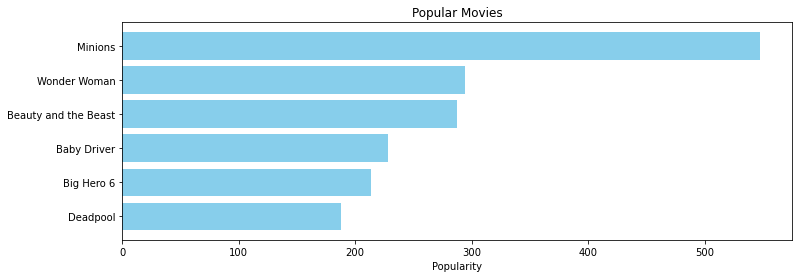

In [114]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# Content Based Filtering num1

In [20]:
df2=df1.copy()

In [21]:
df2.dtypes

budget           object
genres           object
id                int32
overview         object
popularity       object
release_date     object
revenue         float64
runtime         float64
title            object
vote_average    float64
vote_count      float64
keywords         object
cast             object
crew             object
dtype: object

In [22]:
df2.shape

(46496, 14)

In [23]:
print('budgetMin=',budgetMin)
print('revenueMin=',revenueMin)
print('popularityMin=',popularityMin)
print('vote_countMin=',vote_countMin)
print('yearMin=',yearMin)

budgetMin= 1000000
revenueMin= 1000000
popularityMin= 3.6
vote_countMin= 34
yearMin= 2011


In [24]:
df2 = df2.drop(df2.loc[df2['budget'].isnull()].index) #delete the rows with NULLS values in 'budget'
df2["budget"] = pd.to_numeric(df2["budget"], downcast='integer',errors='coerce')#force all the budget values to be numeric
df2=df2.drop(df2.loc[df2['revenue'].isnull()].index) #delete the rows with NULLS values in 'revenue'
df2["revenue"] = pd.to_numeric(df2["revenue"], downcast='integer',errors='coerce')#force all the values to be numeric
df2=df2.drop(df2.loc[df2['popularity'].isnull()].index) #delete the rows with NULLS values in 'popularity'
df2["popularity"] = pd.to_numeric(df2["popularity"], downcast='integer',errors='coerce')#force all the values to be numeric
df2=df2.drop(df2.loc[df2['vote_count'].isnull()].index) #delete the rows with NULLS values in 'vote_count'
df2["vote_count"] = pd.to_numeric(df2["vote_count"], downcast='integer',errors='coerce')#force all the values to be numeric


In [25]:
df2 = df2.drop(df2.loc[df2['budget']<budgetMin].index) #delete the rows with values<budgetMin in 'budget'
df2= df2.drop(df2.loc[df2['revenue']<revenueMin].index) #delete the rows with values<revenueMin in 'revenue'
df2= df2.drop(df2.loc[df2['popularity']<popularityMin].index) #delete the rows with values<popularityMin in 'popularity'
df2= df2.drop(df2.loc[df2['vote_count']<vote_countMin].index) #delete the rows with values<vote_countMin in 'vote_count'

df2['newYear']=df2['release_date'].str.split('-|/', expand=True)[0]
df2["newYear"] = pd.to_numeric(df2["newYear"],errors='coerce')
if yearMin!=0:
    df2 = df2.drop(df2.loc[df2['newYear']<yearMin].index) #delete the rows with 'newYear'<yearMin 
df2.drop(['release_date'], axis='columns', inplace=True)

In [26]:
df2.dtypes

budget            int32
genres           object
id                int32
overview         object
popularity      float64
release_date     object
revenue           int64
runtime         float64
title            object
vote_average    float64
vote_count        int16
keywords         object
cast             object
crew             object
dtype: object

In [27]:
df2.shape

(4094, 14)

In [28]:
df2.head(2)

,budget,genres,id,overview,popularity,release_date,revenue,runtime,title,vote_average,vote_count,keywords,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033,81.0,Toy Story,7.7,5415,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249,104.0,Jumanji,6.9,2413,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."


In [29]:
df2['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
3    Cheated on, mistreated and stepped on, the wom...
5    Obsessive master thief, Neil McCauley leads a ...
8    International action superstar Jean Claude Van...
Name: overview, dtype: object

In [30]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4094, 18939)

In [31]:
tfidf_matrix[1][0]

<1x18939 sparse matrix of type '<class 'numpy.float64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [32]:
df2['overview'].head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
3    Cheated on, mistreated and stepped on, the wom...
5    Obsessive master thief, Neil McCauley leads a ...
8    International action superstar Jean Claude Van...
Name: overview, dtype: object

In [33]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [34]:
cosine_sim

array([[1.        , 0.01960449, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01960449, 1.        , 0.        , ..., 0.011823  , 0.        ,
        0.0867484 ],
       [0.        , 0.        , 1.        , ..., 0.04876393, 0.        ,
        0.        ],
       ...,
       [0.        , 0.011823  , 0.04876393, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.0867484 , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [35]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [36]:
indices

title
Toy Story                            0
Jumanji                              1
Waiting to Exhale                    3
Heat                                 5
Sudden Death                         8
                                 ...  
Dunkirk                          45711
Transformers: The Last Knight    45873
The Dark Tower                   46045
The Emoji Movie                  46170
Wind River                       46198
Length: 4094, dtype: int64

In [37]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [38]:
df2['title'].head()

0            Toy Story
1              Jumanji
3    Waiting to Exhale
5                 Heat
8         Sudden Death
Name: title, dtype: object

In [41]:
get_recommendations('Toy Story')

15415               Toy Story 3
3008                Toy Story 2
10337    The 40 Year Old Virgin
11444    For Your Consideration
3068            Man on the Moon
448           For Love or Money
2165          Indecent Proposal
10624               Match Point
16764              Burke & Hare
1892             Child's Play 3
Name: title, dtype: object

In [40]:
get_recommendations('Jumanji')

30480                     Pixels
19800             Wreck-It Ralph
2494                    eXistenZ
10931                 Stay Alive
14234                      Gamer
7938        The Last Starfighter
5152                  Panic Room
3883          Dungeons & Dragons
11449              Casino Royale
23824    Guardians of the Galaxy
Name: title, dtype: object

In [119]:
get_recommendations('The Goonies')

60                                    Johnny Mnemonic
8                                    Cutthroat Island
3454                              That Awkward Moment
1315                               Look Who's Talking
3997                                      Bad Santa 2
657                             The NeverEnding Story
3160    The Pirates! In an Adventure with Scientists!
2077                                       The Wraith
1064                                    Shanghai Noon
3266                                   Gangster Squad
Name: title, dtype: object

In [121]:
get_recommendations('Thor')

3400                  Thor: The Dark World
3326                          Man of Steel
1456                               Jason X
4006                  The Space Between Us
95                                Stargate
3161                            Prometheus
2601                                 Ponyo
3740    Batman v Superman: Dawn of Justice
3721                            Little Boy
2712                            Surrogates
Name: title, dtype: object

In [123]:
get_recommendations('Batman Begins')

50                    Batman Forever
965     Batman: Mask of the Phantasm
182                           Batman
405                   Batman Returns
3091           The Dark Knight Rises
2466                 The Dark Knight
4036           The Lego Batman Movie
1617                  Bruce Almighty
3339                     Hummingbird
2480                     Speed Racer
Name: title, dtype: object

# Content Based Filtering num2

Credits, Genres and Keywords Based Recommender

In [42]:
df2.shape

(4094, 14)

In [43]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [44]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [45]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []
# Define new director, cast, g

In [46]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [47]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
3,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker,"[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]"


In [48]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [49]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [50]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [51]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [52]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [53]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [118]:
get_recommendations('Toy Story', cosine_sim2)

941                     Toy Story 2
2829                    Toy Story 3
2194                  Monster House
3003                         Cars 2
2153                 The Shaggy Dog
2212                           Zoom
2566    Madagascar: Escape 2 Africa
2584                           Igor
4076                         Cars 3
179                         Aladdin
Name: title, dtype: object

In [117]:
get_recommendations('Jumanji', cosine_sim2)

2720                    Where the Wild Things Are
177                                The Pagemaster
2555                                City of Ember
2433                              The Water Horse
627                                  Return to Oz
731                        Santa Claus: The Movie
3318                                         Epic
3974    Middle School: The Worst Years of My Life
252                              The Wizard of Oz
324                            The Princess Bride
Name: title, dtype: object

In [122]:
get_recommendations('The Goonies', cosine_sim2)

2677                                Aliens in the Attic
170                                   Super Mario Bros.
264                     Around the World in Eighty Days
540                                     Lethal Weapon 4
593                                     Lethal Weapon 2
594                                     Lethal Weapon 3
614                             Honey I Blew Up the Kid
615                            Honey, I Shrunk the Kids
1950    Lemony Snicket's A Series of Unfortunate Events
1964                  Charlie and the Chocolate Factory
Name: title, dtype: object

In [120]:
get_recommendations('Thor', cosine_sim2)

3400                      Thor: The Dark World
4044                        Kong: Skull Island
2521     The Mummy: Tomb of the Dragon Emperor
1455                         The Scorpion King
2031                            Fantastic Four
2346    Fantastic 4: Rise of the Silver Surfer
2689                                   G-Force
2839                 The Sorcerer's Apprentice
145                           Last Action Hero
165                                 The Shadow
Name: title, dtype: object

In [124]:
get_recommendations('Batman Begins', cosine_sim2)

2466          The Dark Knight
3091    The Dark Knight Rises
1384        Lone Wolf McQuade
2247             The Prestige
3481           Brick Mansions
3670            Run All Night
1318              Next of Kin
2918                   Faster
3000                   Takers
3068               The Double
Name: title, dtype: object

# collaborative filter

## dataset 200k_rows - algoritm: SVD - test_type: cross_validate

the singular value decomposition (SVD) is a factorization of matrix M:

U Sigma V where U is an mxm unitary matrix, 

Sigma is an mxn rectangular diagonal matrix 

V is an nxn unitary matrix. 

#### The lower the RMSE, the better the performance.

In [54]:
from surprise import Reader, Dataset, SVD#, => evaluate it is deprecated, usa next line
from surprise.model_selection import cross_validate

In [55]:
reader = Reader()
ratings = pd.read_csv('./data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [56]:
ratings.shape

(100004, 4)

In [57]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [58]:
#data.split(n_folds=5) => see https://surprise.readthedocs.io/en/stable/getting_started.html

In [59]:
algo = SVD()

In [60]:
# Run 5-fold cross-validation and then print results
# old=> evaluate(svd, data, measures=['RMSE', 'MAE']) use instead =>
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8938  0.9098  0.8942  0.8919  0.8914  0.8962  0.0069  
MAE (testset)     0.6875  0.6998  0.6879  0.6897  0.6852  0.6900  0.0051  
Fit time          4.52    4.28    4.28    4.92    4.76    4.55    0.26    
Test time         0.19    0.13    0.19    0.13    0.19    0.16    0.03    


{'test_rmse': array([0.89375988, 0.90982106, 0.8941606 , 0.89192582, 0.89139671]),
 'test_mae': array([0.6874991 , 0.69979172, 0.68793049, 0.68969505, 0.68518067]),
 'fit_time': (4.52141261100769,
  4.275573492050171,
  4.277538061141968,
  4.9158196449279785,
  4.75932240486145),
 'test_time': (0.18649911880493164,
  0.1256551742553711,
  0.1865229606628418,
  0.12766242027282715,
  0.18650174140930176)}

ERRORS:

RMSE Root Mean Sqaure Error 0.8766  quadratic scoring 

MAE Mean absolute error 0.6731 measures the average magnitude of the errors in a set of forecasts

RMSE 0.8766

In [61]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [62]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


Prediction(uid=1, iid=302, r_ui=3, est=2.756291780279027, details={'was_impossible': False})

pred = algo.predict(uid, iid, r_ui=4, verbose=True)

uid = 1  # raw user id

iid = str(302)  # raw movie id 

r_ui = 4 real rating

In [63]:
algo.predict(1, 31, 2.5)

Prediction(uid=1, iid=31, r_ui=2.5, est=2.4538357865124816, details={'was_impossible': False})

In [64]:
algo.predict(1, 2105, 4)

Prediction(uid=1, iid=2105, r_ui=4, est=2.966452109509793, details={'was_impossible': False})

In [65]:
algo.predict(1, 3671, 3)

Prediction(uid=1, iid=3671, r_ui=3, est=3.197527493803201, details={'was_impossible': False})

In [66]:
algo.predict(1, 1405, 1)

Prediction(uid=1, iid=1405, r_ui=1, est=2.0106546884645384, details={'was_impossible': False})

In [67]:
ratings[ratings['userId'] == 100]

,userId,movieId,rating,timestamp
15273,100,1,4.0,854193977
15274,100,3,4.0,854194024
15275,100,6,3.0,854194023
15276,100,7,3.0,854194024
15277,100,25,4.0,854193977
15278,100,32,5.0,854193977
15279,100,52,3.0,854194056
15280,100,62,3.0,854193977
15281,100,86,3.0,854194208
15282,100,88,2.0,854194208


In [68]:
algo.predict(100, 1, 4)

Prediction(uid=100, iid=1, r_ui=4, est=3.6159894472617187, details={'was_impossible': False})

In [69]:
algo.predict(100, 1073, 5)

Prediction(uid=100, iid=1073, r_ui=5, est=3.9373470252847333, details={'was_impossible': False})

In [70]:
algo.predict(100, 88, 2)

Prediction(uid=100, iid=88, r_ui=2, est=2.7636786750929843, details={'was_impossible': False})

In [71]:
ratings[ratings['userId'] == 200]

,userId,movieId,rating,timestamp
27425,200,1,3.0,1437932719
27426,200,2,3.5,1457721108
27427,200,32,4.0,1437934584
27428,200,110,3.5,1438019199
27429,200,145,4.5,1437933154
...,...,...,...,...
27673,200,106920,3.5,1438025417
27674,200,111659,4.0,1438026414
27675,200,129354,4.0,1457720823
27676,200,134130,4.5,1457123787


In [72]:
algo.predict(200, 110, 3.5)

Prediction(uid=200, iid=110, r_ui=3.5, est=4.063601022237693, details={'was_impossible': False})

In [73]:
algo.predict(200, 136592, 1.5)

Prediction(uid=200, iid=136592, r_ui=1.5, est=2.7724554178186076, details={'was_impossible': False})

In [74]:
algo.predict(200, 134130, 4.5)

Prediction(uid=200, iid=134130, r_ui=4.5, est=3.8189685434817884, details={'was_impossible': False})

# official tutorial
https://surprise.readthedocs.io/en/stable/getting_started.html

# dataset 200k_rows - algoritm: NormalPredictor - test_type: cross_validate

Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.

In [75]:
from surprise import NormalPredictor

In [76]:
dfratings=pd.read_csv('./data/ratings_small.csv')
dfnp=dfratings.copy()

In [77]:
dfnp=dfratings.copy()
dfnp.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [78]:
dfnp.drop(columns='timestamp', inplace=True, errors='raise')

In [79]:
dfnp.shape

(100004, 3)

In [80]:
reader = Reader()
data = Dataset.load_from_df(dfnp[['userId', 'movieId', 'rating']], reader)
cross_validate(NormalPredictor(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4344  1.4435  1.4435  1.4364  1.4485  1.4413  0.0052  
MAE (testset)     1.1438  1.1545  1.1537  1.1440  1.1555  1.1503  0.0052  
Fit time          0.10    0.13    0.13    0.13    0.13    0.12    0.01    
Test time         0.18    0.11    0.18    0.11    0.18    0.15    0.03    


{'test_rmse': array([1.43440029, 1.44354505, 1.44348522, 1.43638532, 1.44845612]),
 'test_mae': array([1.14380014, 1.15446675, 1.15371489, 1.14403278, 1.15548123]),
 'fit_time': (0.10272932052612305,
  0.13071179389953613,
  0.12763547897338867,
  0.12865185737609863,
  0.13164687156677246),
 'test_time': (0.17950057983398438,
  0.10870933532714844,
  0.1785445213317871,
  0.10870862007141113,
  0.17752909660339355)}

In [81]:
#RMSE 1.43

#  dataset 200k_rows algoritm: SVD, test_type:  train and test 

In [82]:
from surprise import accuracy
from surprise.model_selection import train_test_split

In [83]:
dfratings_small=pd.read_csv('./data/ratings_small.csv')
dftt=dfratings_small.copy()
dftt.shape

(100004, 4)

In [84]:
dftt.drop(columns='timestamp', inplace=True, errors='raise')
dftt.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [85]:
dftt.shape

(100004, 3)

In [86]:
reader = Reader()
data = Dataset.load_from_df(dftt[['userId', 'movieId', 'rating']], reader)


In [87]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [88]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8961


0.8961184645421129

In [89]:
# RMSE: 0.9015 in train and test / RMSE 0.8766 with cross validation

#  dataset 1M_rows algoritm: SVD, test_type:  train and test 

In [90]:
# bigger database (1Milion)

In [91]:
#import data
dfratings_big=pd.read_csv('./data/ratings.csv')
dfb=dfratings_big.copy()
dfb.shape

(26024289, 4)

In [92]:
#select first 1M rows
df1M=dfb.iloc[0:1000000]
df1M.shape

(1000000, 4)

In [93]:
#prepare data
reader = Reader()
data = Dataset.load_from_df(df1M[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [94]:
algo = SVD()
predictions = algo.fit(trainset).test(testset)

In [95]:
accuracy.rmse(predictions)

RMSE: 0.8362


0.8362203692697034

In [96]:
#RMSE: 0.836 in train and test 1M / RMSE: 0.9015 in train and test small (220k)

from RMSE: 0.9047 to RMSE: 0.8379

# dataset 10M_rows algoritm: SVD, test_type: train and test

In [97]:
# 1M database
df10M=dfb.iloc[0:1000000]
df10M.shape

(1000000, 4)

In [98]:
#prepare data 
reader = Reader()
data = Dataset.load_from_df(df10M[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8391


0.8390617454969014

In [99]:
#RMSE: 0.806 in train and test 10M /RMSE: 0.836 in train and test 1M 

## dataset 1M_rows algoritm: SVD, test_type: cross_validate

In [100]:
#select first 1M rows
#select first 1M rows
df1M=dfb.iloc[0:1000000]
df1M.shape
#prepare data
reader = Reader()
data = Dataset.load_from_df(df1M[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8328  0.8341  0.8313  0.8331  0.8348  0.8332  0.0012  
MAE (testset)     0.6352  0.6352  0.6337  0.6339  0.6353  0.6347  0.0007  
Fit time          44.37   50.91   62.23   50.92   44.38   50.56   6.52    
Test time         2.13    5.26    1.91    2.01    1.76    2.61    1.33    


{'test_rmse': array([0.83278287, 0.8341281 , 0.83125836, 0.83312636, 0.8347582 ]),
 'test_mae': array([0.6351524 , 0.63524125, 0.63366021, 0.63393071, 0.63531017]),
 'fit_time': (44.37364673614502,
  50.905120611190796,
  62.226489543914795,
  50.92165398597717,
  44.377615451812744),
 'test_time': (2.125277280807495,
  5.260787010192871,
  1.9148848056793213,
  2.012848377227783,
  1.7562596797943115)}

In [101]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [102]:
algo.predict(1, 31, 2.5) #est=2.45

Prediction(uid=1, iid=31, r_ui=2.5, est=3.6943668464669974, details={'was_impossible': False})

In [103]:
algo.predict(1, 2105, 4) #est=2.95

Prediction(uid=1, iid=2105, r_ui=4, est=3.840835842866246, details={'was_impossible': False})

In [104]:
algo.predict(1, 3671, 3) #est=3.02

Prediction(uid=1, iid=3671, r_ui=3, est=4.42513645134105, details={'was_impossible': False})

In [105]:
algo.predict(1, 1405, 1) #est=2.01

Prediction(uid=1, iid=1405, r_ui=1, est=3.4839797189448483, details={'was_impossible': False})

In [106]:
algo.predict(100, 1, 4) #est=3.61

Prediction(uid=100, iid=1, r_ui=4, est=3.539903992697792, details={'was_impossible': False})

In [107]:
algo.predict(100, 1073, 5) #est=3.93

Prediction(uid=100, iid=1073, r_ui=5, est=3.563382850730388, details={'was_impossible': False})

In [108]:
algo.predict(100, 88, 2) #est=2.76

Prediction(uid=100, iid=88, r_ui=2, est=3.0112551868675888, details={'was_impossible': False})

In [109]:
algo.predict(100, 1, 4) #est=3.61

Prediction(uid=100, iid=1, r_ui=4, est=3.539903992697792, details={'was_impossible': False})

In [110]:
algo.predict(200, 110, 4) #est=3.32

Prediction(uid=200, iid=110, r_ui=4, est=4.014951919996355, details={'was_impossible': False})

In [111]:
algo.predict(200, 136592, 1.5) #est=2.7

Prediction(uid=200, iid=136592, r_ui=1.5, est=3.5880933718823687, details={'was_impossible': False})

In [112]:
algo.predict(200, 134130, 4.5) #est=3.81

Prediction(uid=200, iid=134130, r_ui=4.5, est=3.967676954765037, details={'was_impossible': False})

In [113]:
#database, algorthm, method  => error
#200k, NormalPredictor, crossvalidation  => 1.437
#200k, SVD, test&train      => 0.900
#200k, SVD, crossvalidation => 0.897
#1M,   SVD, test&train      => 0.837
#10M,  SVD, test&train      => 0.837
#1M,   SVD, crossvalidation => 0.833

In [ ]:
# note: the bigger databases have not good 'distribution'...(?)